In [1]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch

import sys, os
from models.subpix_rcnn import SubpixRCNN
from utils import move_data_to_device, move_dict_to_cpu, plot_image_boxes, evaluate_predictions
from data_simulator import PsfDataset
from scripts.plotting import PlotController
from scripts.evaluating import test_model_fixed_snr, test_model_once_plot

In [6]:
# Instantiate the datasets.
num_spots_min = 2
num_spots_max = 20
sigma_mean = 2.0
sigma_std = 0.0
snr_mean = 10
snr_std = 0.2
base_noise_min = 50
base_noise_max = 150
use_gauss_noise = True
gauss_noise_std = 10
img_w, img_h = 64, 64

# Instantiate the datasets.
train_dataset = PsfDataset( 1,
                            200,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )

valid_dataset = PsfDataset( 2,
                            5,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )

device = 'cpu'
backbone = resnet_fpn_backbone("resnet50", pretrained=True)
kwargs = {"nms_tresh": 0.1, "detections_per_img": None}
model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device=device)
path = r"/Users/august/Desktop/bachelor/bachelor1/testmodel_noise_added.pth"
model.load_state_dict(torch.load(path, map_location=device))
model.eval()



Custom SubpixRoIHeads successfully initialized!


/var/folders/sr/ychn_0nn4b54j0qp8gmljtr80000gn/T/ipykernel_71902/3629169364.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_l

SubpixRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

{'precision': 0.7058823529411765, 'recall': 0.6666666666666666, 'avg f1': 0.6857142857142857, 'avg ji': 0.5217391304347826, 'avg loc error': 0.3483467400074005}


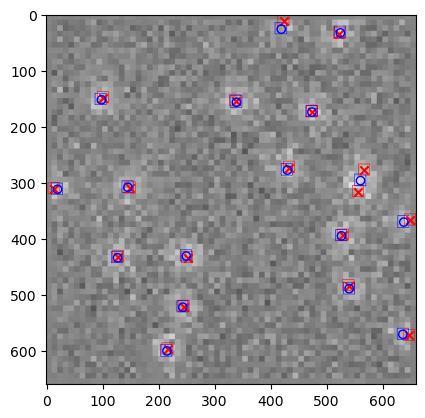

In [10]:
test_model_once_plot(model, train_dataset, torch.device('cpu'),'simple')

In [3]:
# Try evaluating at fixed SNR...
result = test_model_fixed_snr(model, snr=5, start_density=0.1, end_density=1, 
                              step_density=0.1, num_images=20, device=torch.device('cpu'))
print(result)

4
Density: 0.1, Metrics: {'precision': 0.38250000000000006, 'recall': 0.2375, 'avg f1': 0.2782936507936508, 'avg ji': 0.19845238095238096, 'avg loc error': tensor(0.1401)}
8
Density: 0.2, Metrics: {'precision': 0.495, 'recall': 0.1625, 'avg f1': 0.2261188811188811, 'avg ji': 0.13776515151515153, 'avg loc error': tensor(0.2039)}
12
Density: 0.30000000000000004, Metrics: {'precision': 0.5230952380952381, 'recall': 0.2083333333333334, 'avg f1': 0.2848304584991892, 'avg ji': 0.1744952596423185, 'avg loc error': tensor(0.3206)}
16
Density: 0.4, Metrics: {'precision': 0.6333134920634921, 'recall': 0.2125, 'avg f1': 0.306772096683323, 'avg ji': 0.1891774245930256, 'avg loc error': tensor(0.2948)}
20
Density: 0.5, Metrics: {'precision': 0.6068055555555556, 'recall': 0.185, 'avg f1': 0.2724480650533875, 'avg ji': 0.16320253659384093, 'avg loc error': tensor(0.2915)}
24
Density: 0.6000000000000001, Metrics: {'precision': 0.46929653679653677, 'recall': 0.1625, 'avg f1': 0.23540297958540451, 'avg 

In [6]:
# Turn results into a dataframe. I want to be able to plot the keys against avg ji.
import pandas as pd
df = pd.DataFrame(result)
df.head()



,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
precision,0.3825,0.495,0.523095,0.633313,0.606806,0.469297,0.402352,0.445335,0.472468,0.405119
recall,0.2375,0.1625,0.208333,0.2125,0.185,0.1625,0.091071,0.110937,0.129167,0.10125
avg f1,0.278294,0.226119,0.28483,0.306772,0.272448,0.235403,0.137645,0.173157,0.198566,0.159139
avg ji,0.198452,0.137765,0.174495,0.189177,0.163203,0.145118,0.079839,0.098035,0.113678,0.088785
avg loc error,tensor(0.1401),tensor(0.2039),tensor(0.3206),tensor(0.2948),tensor(0.2915),tensor(0.2665),tensor(0.2040),tensor(0.2797),tensor(0.3342),tensor(0.2984)


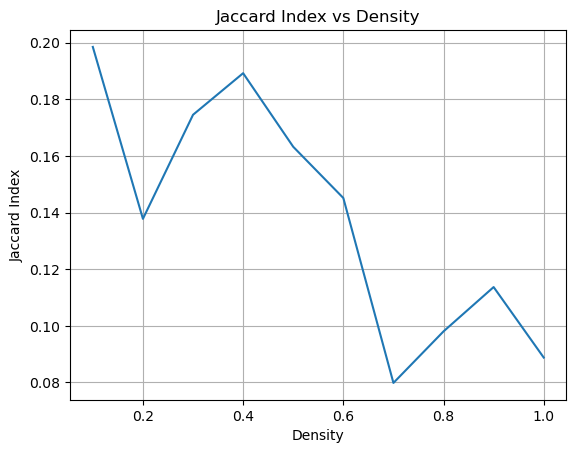

In [7]:
# Plot the JI against density
import matplotlib.pyplot as plt
densities = [float(col) for col in df.columns]
ji_values = df.loc['avg ji'].astype(float).values
plt.plot(densities, ji_values)
plt.xlabel('Density')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index vs Density')
plt.grid()
plt.show()

In [ ]:
# THERE IS A PROBLEM WITH THE TARGET GENERATION
# When i use dataloader, target is a dict with batches..? So the dict elements are tensors with
# the wrong shape.

# WHAT SHOULD BE SIZE OF PSFS?

<class 'dict'>
<class 'dict'>


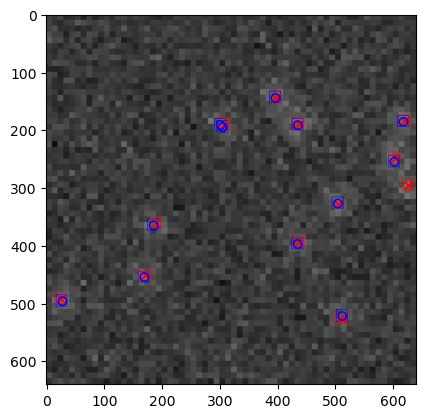

TypeError: string indices must be integers, not 'str'

In [11]:
dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)
device = torch.device('cpu')
model.eval()
for i, (image, target) in enumerate(dataloader):
    # Move data to device
    image = move_data_to_device(image, device)
    target = move_data_to_device(target, device)
    image = image.squeeze(0)
    target['boxes'] = target['boxes'].squeeze(0)
    target['positions'] = target['positions'].squeeze(0)
    # Run the model
    with torch.no_grad():
        predictions = model([image])
    # Plot the image and boxes
    print(type(predictions[0]))
    print(type(target))
    PlotController(image, target, predictions[0], type='image')
    # Evaluate the predictions
    evaluate_predictions(predictions, target)

{'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'avg f1': 0.8571428571428571, 'avg ji': 0.75, 'avg loc error': 0.25412091612815857}


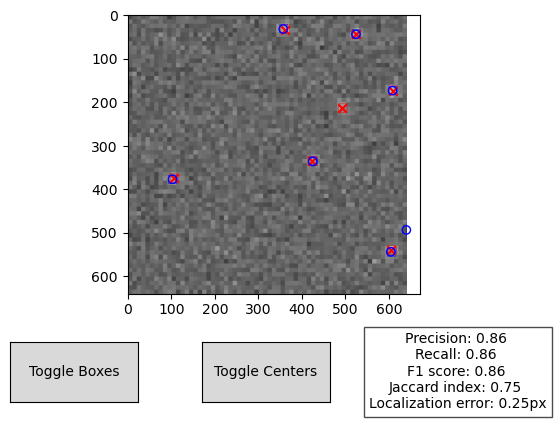

'\n\nwhile True:\n    idx = input("Enter validation image index (or \'q\' to quit): ")\n    if idx.lower() == \'q\':\n        break\n    idx = int(idx)\n    img, tar = valid_dataset[idx]\n    img = move_data_to_device(img, device)\n    tar = move_data_to_device(tar, device)\n    with torch.no_grad():\n        out = model([img])[0]\n    move_dict_to_cpu(tar)\n    move_dict_to_cpu(out)\n    plot_image_boxes(img, tar, out, True, True)\n    print(out)\n    print(tar)\n    eval = evaluate_predictions(out, tar, 0.5)\n    print(eval) '

In [15]:

# ...existing code to load model...

# imgs = []
# tars = []

# for i in range(10):
#     img, tar = valid_dataset[i]
#     img = move_data_to_device(img, device)
#     tar = move_data_to_device(tar, device)
#     imgs.append(img)
#     tars.append(tar)
# with torch.no_grad():
#     out = model(imgs)
# eval = evaluate_predictions(out, tars, 0.5)
# print(eval)

img, tar = valid_dataset[1]
img = move_data_to_device(img, device)
tar = move_data_to_device(tar, device)
with torch.no_grad():
    out = model([img])
eval = evaluate_predictions(out, [tar], 0.5)
print(eval)
out = out[0]
move_dict_to_cpu(tar)
move_dict_to_cpu(out)

from scripts.plotting import PlotController
# Create an instance of the PlotController
plot_controller = PlotController(img, tar, out, 'buttons')


# #plot_image_boxes(img, tar, out, True, True)
# print(out)
# print(tar)


"""

while True:
    idx = input("Enter validation image index (or 'q' to quit): ")
    if idx.lower() == 'q':
        break
    idx = int(idx)
    img, tar = valid_dataset[idx]
    img = move_data_to_device(img, device)
    tar = move_data_to_device(tar, device)
    with torch.no_grad():
        out = model([img])[0]
    move_dict_to_cpu(tar)
    move_dict_to_cpu(out)
    plot_image_boxes(img, tar, out, True, True)
    print(out)
    print(tar)
    eval = evaluate_predictions(out, tar, 0.5)
    print(eval) """

